# Spooky Author Identification Challenge

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. 

The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, 

so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.


Feature Engineering

Top Words Of Each Writer And Their Count

TF-IDF Extraction

Training Model

Data

In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import matplotlib
from matplotlib import pyplot as plt
# import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
spooky = pd.read_csv('D:\\R-Projects\\traint.csv') 

spooky.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [3]:
spooky.shape

(19579, 3)

In [4]:
# Let's extract the number of examples of each class
EAP_len = spooky[spooky['author'] == 'EAP'].shape[0]
HPL_len = spooky[spooky['author'] == 'HPL'].shape[0]
MWS_len = spooky[spooky['author'] == 'MWS'].shape[0]


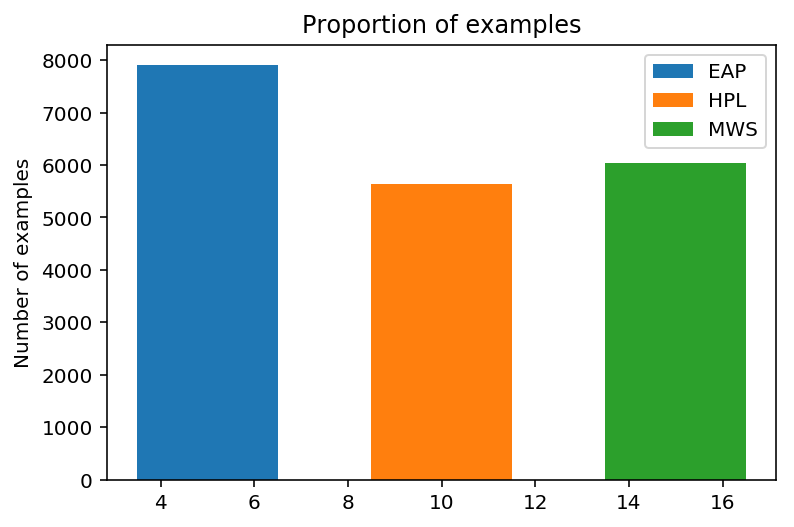

In [5]:
# bar plot of the 3 classes
plt.bar(5,EAP_len,3, label="EAP")
plt.bar(10,HPL_len,3, label="HPL")
plt.bar(15,MWS_len,3, label="MWS")
plt.legend()
plt.ylabel('Number of examples')
plt.title('Proportion of examples')
plt.show()

In [6]:
'''
Here we write a function to remove all the punctuations in our dataset strings
'''


def remove_punctuation(text):
    '''a function for removing punctuation'''
    import string
    # replacing the punctuations with no space, 
    # which in effect deletes the punctuation marks 
    translator = str.maketrans('', '', string.punctuation)#remove punctuations from a text
    # return the text stripped of punctuation marks
    return text.translate(translator)

In [7]:
spooky['text'] = spooky['text'].apply(remove_punctuation)
spooky.head(10)

,id,text,author
0,id26305,This process however afforded me no means of a...,EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,In his left hand was a gold snuff box from whi...,EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,Finding nothing else not even gold the Superin...,HPL
5,id22965,A youth passed in solitude my best years spent...,MWS
6,id09674,The astronomer perhaps at this point took refu...,EAP
7,id13515,The surcingle hung in ribands from my body,EAP
8,id19322,I knew that you could not say to yourself ster...,EAP
9,id00912,I confess that neither the structure of langua...,MWS


In [8]:
'''
Now we need to identfy and remove all the stop words in our dataset.
'''
# extracting the stopwords from nltk library
sw = stopwords.words('english')
# displaying the stopwords
np.array(sw)

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself',
       'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her',
       'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them',
       'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom',
       'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'm

In [9]:
print("Number of stopwords: ", len(sw))

Number of stopwords:  179


In [10]:
'''
Now this is the function to remove all the stopwords in the text
'''
def stopwords(text):
    '''a function for removing the stopword'''
    # removing the stop words and lowercasing the selected words
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    # joining the list of words with space separator
    return " ".join(text)

In [11]:
'''
Now we Apply the function to each examples
'''
spooky['text'] = spooky['text'].apply(stopwords)
spooky.head(10)

,id,text,author
0,id26305,process however afforded means ascertaining di...,EAP
1,id17569,never occurred fumbling might mere mistake,HPL
2,id11008,left hand gold snuff box capered hill cutting ...,EAP
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS
4,id12958,finding nothing else even gold superintendent ...,HPL
5,id22965,youth passed solitude best years spent gentle ...,MWS
6,id09674,astronomer perhaps point took refuge suggestio...,EAP
7,id13515,surcingle hung ribands body,EAP
8,id19322,knew could say stereotomy without brought thin...,EAP
9,id00912,confess neither structure languages code gover...,MWS


We want to Collect vocabulary count in our text dataset

We will not use word counts as feature for NLP since tf-idf is a better metric

Also we will Store the vocab and counts in a pandas dataframe

In [12]:
# create a count vectorizer object
count_vectorizer = CountVectorizer()
# fit the count vectorizer using the text data
count_vectorizer.fit(spooky['text'])
# collect the vocabulary items used in the vectorizer
dictionary = count_vectorizer.vocabulary_.items()  

In [13]:
'''
Let's now store our vocabularies
'''

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_bef_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_bef_stem = vocab_bef_stem.sort_values(ascending=False)

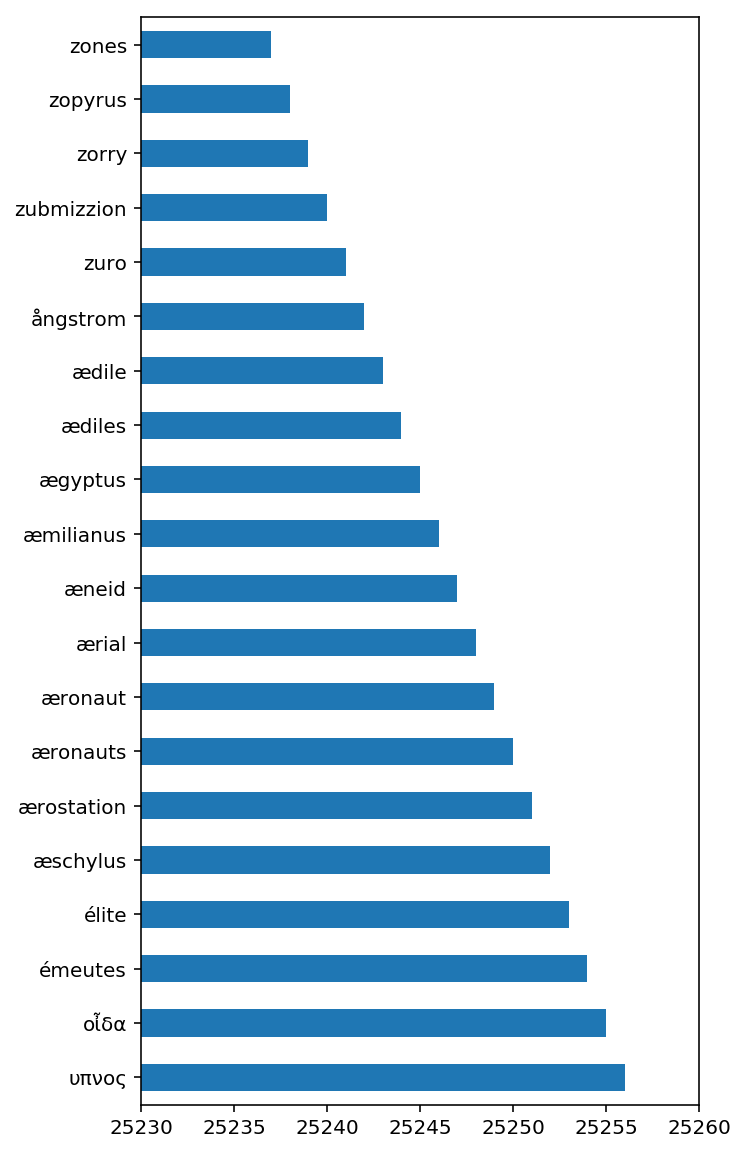

In [14]:
'''
Let's try plot our vocabularies
'''
top_vacab = vocab_bef_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (25230, 25260))

Convert Words to their Base Forms

When processing NLP dataset some words look alike, or often notice that there are various grammatical forms of the same word. 

For instance, “go”, “going” and “gone” are forms of the same verb, “go”.

While the necessities of your project may require you to retain words in various grammatical forms, let us discuss a way to convert various grammatical forms of the same word into its base form. There are two techniques that you can use to convert a word to its base.


The first technique is stemming. Stemming is a simple algorithm that removes affixes from a word. There are various stemming algorithms available for use in NLTK. We will use the Porter algorithm in this tutorial.

We first import PorterStemmer from nltk.stem.porter. Next, we initialize the stemmer to the stemmer variable and then use the .stem() method to find the base form of a word.

The output of the code above is go. If you run the stemmer for the other forms of “go” described above, you will notice that the stemmer returns the same base form, “go”. However, as stemming is only a simple algorithm based on removing word affixes, it fails when the words are less commonly used in language.

When you try the stemmer on the word “constitutes”, it gives an unintuitive result.

In [15]:
'''
Now we want to perform stemming operation the below is the function
'''
# create an object of stemming function
stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text) 

In [16]:
'''
Now we want to apply the function to each examples
'''
spooky['text'] = spooky['text'].apply(stemming)
spooky.head(10)

,id,text,author
0,id26305,process howev afford mean ascertain dimens dun...,EAP
1,id17569,never occur fumbl might mere mistak,HPL
2,id11008,left hand gold snuff box caper hill cut manner...,EAP
3,id27763,love spring look windsor terrac sixteen fertil...,MWS
4,id12958,find noth els even gold superintend abandon at...,HPL
5,id22965,youth pass solitud best year spent gentl femin...,MWS
6,id09674,astronom perhap point took refug suggest non l...,EAP
7,id13515,surcingl hung riband bodi,EAP
8,id19322,knew could say stereotomi without brought thin...,EAP
9,id00912,confess neither structur languag code govern p...,MWS


In [17]:
'''
Now how many words after stemming?
'''
#Collect vocabulary count with this function and TfidfVectorizer library

# create the object of tfid vectorizer
tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
tfid_vectorizer.fit(spooky['text'])
# collect the vocabulary items used in the vectorizer
dictionary = tfid_vectorizer.vocabulary_.items()


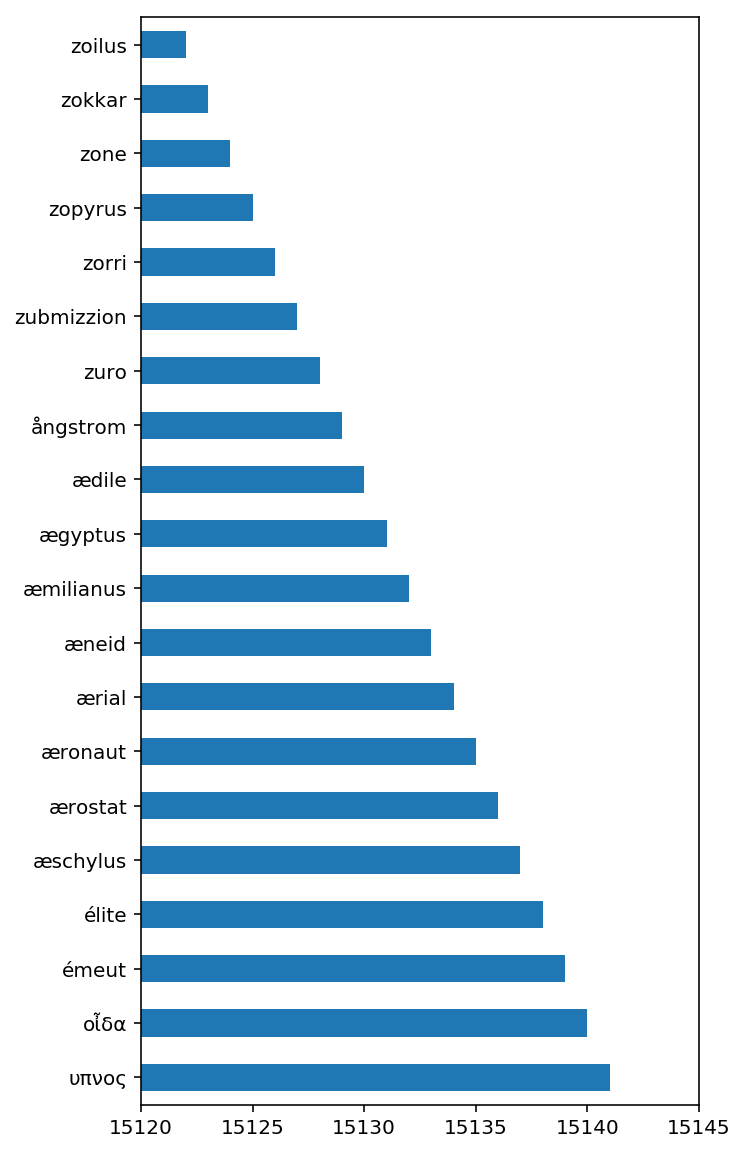

In [18]:
'''
Let's plot our vocabularies using the function
'''
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
vocab_after_stem = pd.Series(count, index=vocab)
# sort the dataframe
vocab_after_stem = vocab_after_stem.sort_values(ascending=False)
# plot of the top vocab
top_vacab = vocab_after_stem.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (15120, 15145))

Let's see the text length of each writer from the below function

In [19]:
'''
This is A function to return the length of text
'''
def length(text):    
    '''a function which returns the length of text'''
    return len(text)

In [20]:
'''
Now we want to apply the function to the example
'''
spooky['length'] = spooky['text'].apply(length)
spooky.head(10)

,id,text,author,length
0,id26305,process howev afford mean ascertain dimens dun...,EAP,136
1,id17569,never occur fumbl might mere mistak,HPL,35
2,id11008,left hand gold snuff box caper hill cut manner...,EAP,113
3,id27763,love spring look windsor terrac sixteen fertil...,MWS,137
4,id12958,find noth els even gold superintend abandon at...,HPL,102
5,id22965,youth pass solitud best year spent gentl femin...,MWS,265
6,id09674,astronom perhap point took refug suggest non l...,EAP,75
7,id13515,surcingl hung riband bodi,EAP,25
8,id19322,knew could say stereotomi without brought thin...,EAP,267
9,id00912,confess neither structur languag code govern p...,MWS,80


In [21]:
'''
Extracting data of each class
'''
EAP_data = spooky[spooky['author'] == 'EAP']
HPL_data = spooky[spooky['author'] == 'HPL']
MWS_data = spooky[spooky['author'] == 'MWS']

'''
Now we want to plot the top words of each writer
'''
Histogram of text lenght of each writer

As we can see the distributions coincides so it better to leave out text length as a feature for predictive modelling

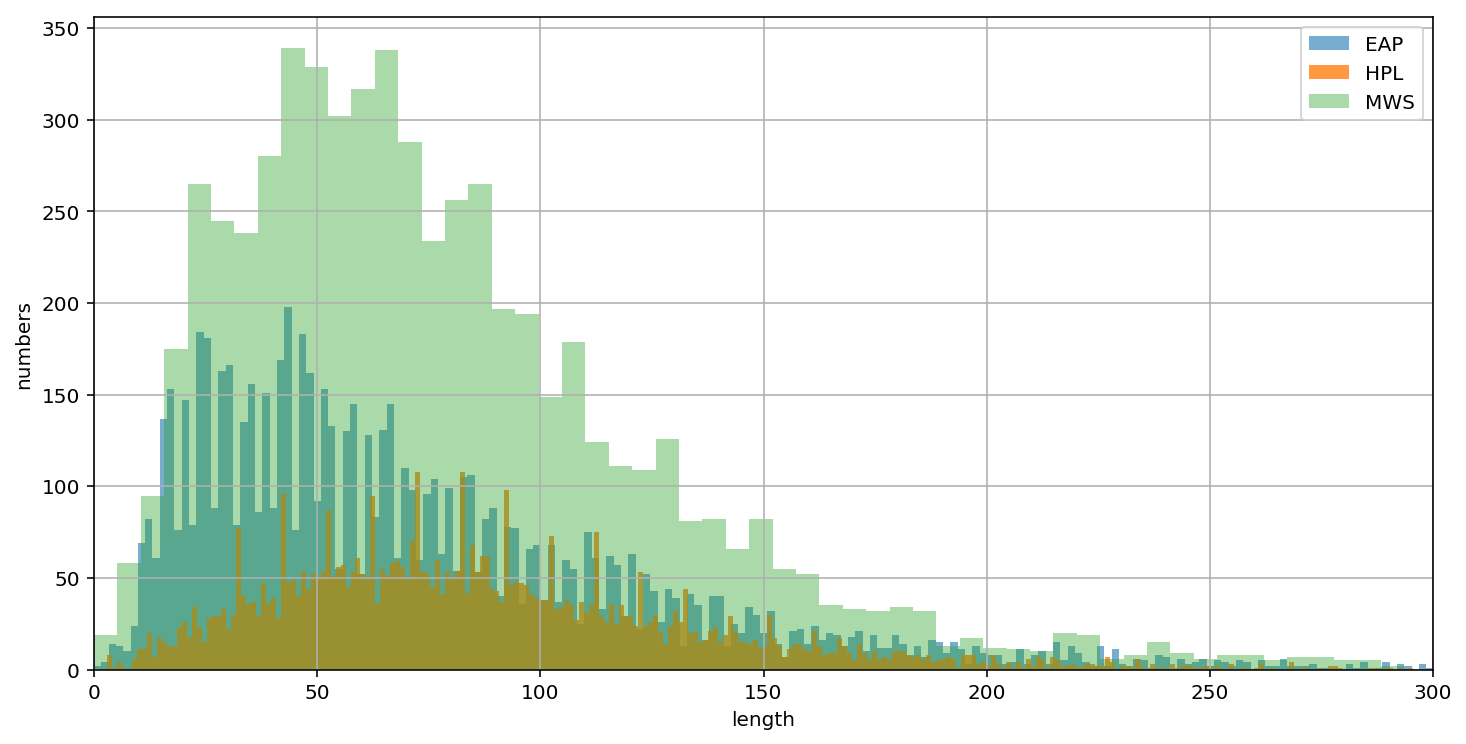

In [22]:
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
bins = 500
plt.hist(EAP_data['length'], alpha = 0.6, bins=bins, label='EAP')
plt.hist(HPL_data['length'], alpha = 0.8, bins=bins, label='HPL')
plt.hist(MWS_data['length'], alpha = 0.4, bins=bins, label='MWS')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,300)
plt.grid()
plt.show()

Now we want to find Top words of each writer and their count

Edgar Allan Poe


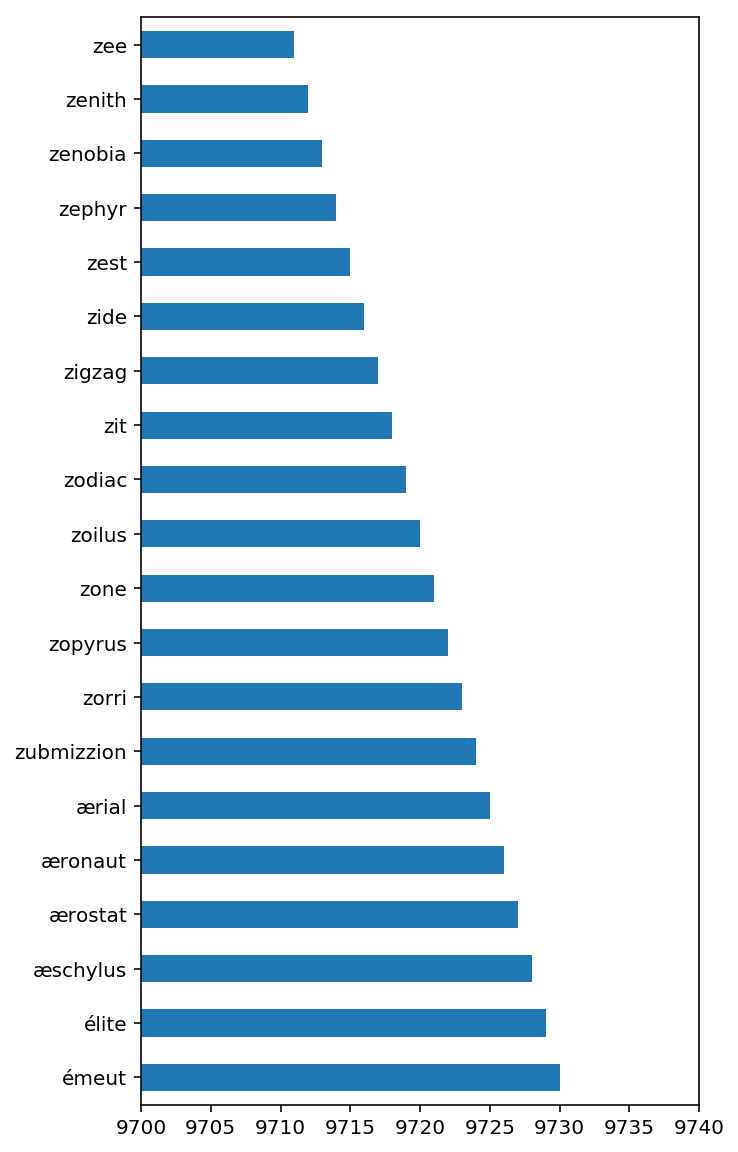

In [23]:
'''
Edgar Allan Poe
'''
# create the object of tfid vectorizer
EAP_tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
EAP_tfid_vectorizer.fit(EAP_data['text'])
# collect the vocabulary items used in the vectorizer
EAP_dictionary = EAP_tfid_vectorizer.vocabulary_.items()

# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in EAP_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index
EAP_vocab = pd.Series(count, index=vocab)
# sort the dataframe
EAP_vocab = EAP_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = EAP_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (9700, 9740))

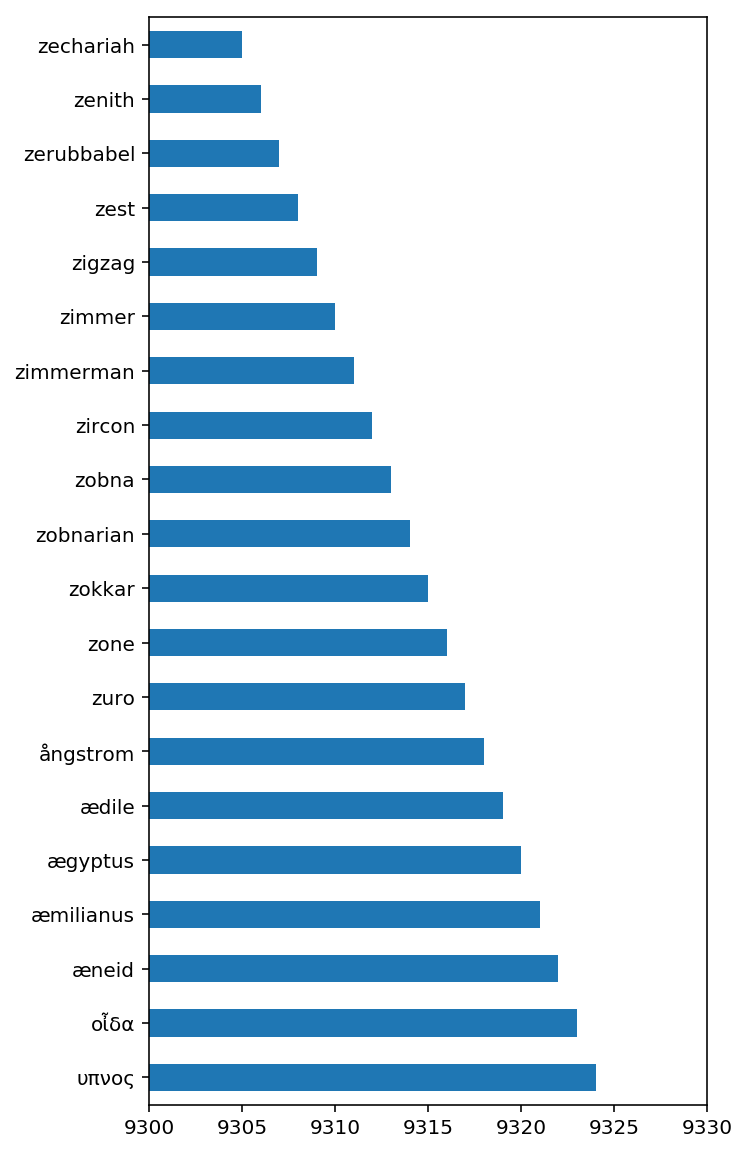

In [ ]:
'''
Mary Shelley
'''

# create the object of tfid vectorizer
HPL_tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
HPL_tfid_vectorizer.fit(HPL_data['text'])
# collect the vocabulary items used in the vectorizer
HPL_dictionary = HPL_tfid_vectorizer.vocabulary_.items()
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated lists
for key, value in HPL_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe with vocab as index    
HPL_vocab = pd.Series(count, index=vocab)
# sort the dataframe
HPL_vocab = HPL_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = HPL_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (9300, 9330))

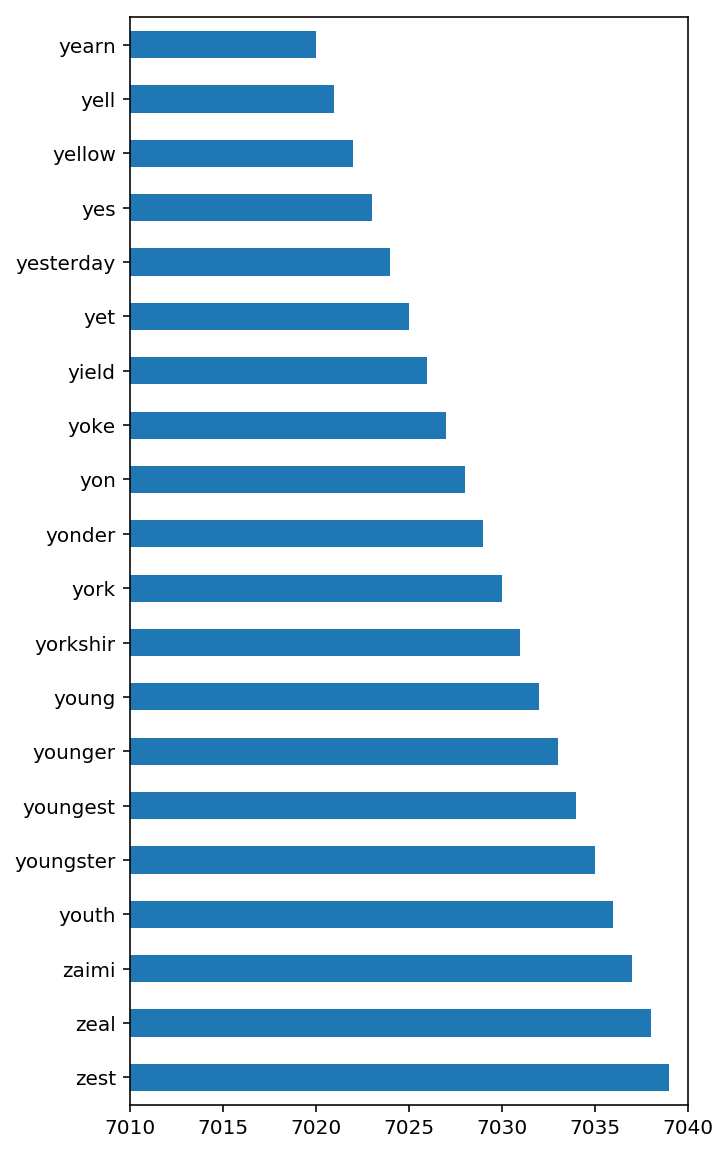

In [ ]:
'''
HP Lovecraft
'''

# create the object of tfid vectorizer
MWS_tfid_vectorizer = TfidfVectorizer("english")
# fit the vectorizer using the text data
MWS_tfid_vectorizer.fit(MWS_data['text'])
# collect the vocabulary items used in the vectorizer
MWS_dictionary = MWS_tfid_vectorizer.vocabulary_.items()
# lists to store the vocab and counts
vocab = []
count = []
# iterate through each vocab and count append the value to designated list
for key, value in MWS_dictionary:
    vocab.append(key)
    count.append(value)
# store the count in panadas dataframe and vocab as index    
MWS_vocab = pd.Series(count, index=vocab)
# sort the dataframe
MWS_vocab = MWS_vocab.sort_values(ascending=False)
# plot of the top vocab
top_vacab = MWS_vocab.head(20)
top_vacab.plot(kind = 'barh', figsize=(5,10), xlim= (7010, 7040))

As we can see the top words of each writer are cleary distinct and are in huge numbers. Word Count or TF-IDF of the can provide a good feature

Let's do TF-IDF Extraction

tf-idf weight is product of two terms:

Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document;

Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).



In [ ]:
'''
This is the function
'''

# extract the tfid representation matrix of the text data
tfid_matrix = tfid_vectorizer.transform(spooky['text'])
# collect the tfid matrix in numpy array
array = tfid_matrix.todense()

In [ ]:
# store the tf-idf array into pandas dataframe
df = pd.DataFrame(array)
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15132,15133,15134,15135,15136,15137,15138,15139,15140,15141
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.266318,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now Training Model


We are going to train Naive Bayes Classifier. Naive Bayes Classifier is a good choice given we have a medium sized dataset, NB classifier scales well and also NB classifier has been historically used in NLP tasks. We will train Multinomial and Bernoulli NB classifier, since they almost always outperfrom Gaussian NB classifier in NLP tasks

Adding the output to the dataframe

In [ ]:
df['output'] = spooky['author']
df['id'] = spooky['id']
df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15134,15135,15136,15137,15138,15139,15140,15141,output,id
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id26305
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HPL,id17569
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id11008
3,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id27763
4,0.0,0.0,0.0,0.0,0.266318,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,HPL,id12958
5,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id22965
6,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id09674
7,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id13515
8,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,EAP,id19322
9,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MWS,id00912


In [ ]:
'''
Features and output of the models
'''
features = df.columns.tolist()
output = 'output'
# removing the output and the id from features
features.remove(output)
features.remove('id')

In [ ]:
#Import neccassary sklearn modules

from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import GridSearchCV

Now we want to do the Tuning Multinomial Naive Bayes Classifier

In [ ]:
'''
List of alpha parameter we are going to try
'''
alpha_list1 = np.linspace(0.006, 0.1, 20)
alpha_list1 = np.around(alpha_list1, decimals=4)
alpha_list1

array([0.006 , 0.0109, 0.0159, 0.0208, 0.0258, 0.0307, 0.0357, 0.0406,
       0.0456, 0.0505, 0.0555, 0.0604, 0.0654, 0.0703, 0.0753, 0.0802,
       0.0852, 0.0901, 0.0951, 0.1   ])

In [ ]:
'''
Gridsearch
GridSearchCV allows us tune parameters of a model through k-fold cross validataion using parameter grid in one go
'''
# parameter grid function
parameter_grid = [{"alpha":alpha_list1}]

In [ ]:
# classifier object
classifier1 = MultinomialNB()
# gridsearch object using 4 fold cross validation and neg_log_loss as scoring paramter
gridsearch1 = GridSearchCV(classifier1,parameter_grid, scoring = 'neg_log_loss', cv = 4)
# fit the gridsearch
gridsearch1.fit(df[features], df[output])

In [ ]:
'''
Now let's Collect results in pandas dataframe
'''
results1 = pd.DataFrame()
# collect alpha list
results1['alpha'] = gridsearch1.cv_results_['param_alpha'].spooky
# collect test scores
results1['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].spooky

In [ ]:
'''
Let's Collect results in pandas dataframe
'''
results1 = pd.DataFrame()
# collect alpha list
results1['alpha'] = gridsearch1.cv_results_['param_alpha'].data
# collect test scores
results1['neglogloss'] = gridsearch1.cv_results_['mean_test_score'].data

In [ ]:
'''
Plot of logloss vs alpha
'''
matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)
plt.plot(results1['alpha'], -results1['neglogloss'])
plt.xlabel('alpha')
plt.ylabel('logloss')
plt.grid()

In [ ]:
print("Best parameter: ",gridsearch1.best_params_)

In [ ]:
print("Best score: ",gridsearch1.best_score_)